In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
from skimage.io import imread
from skimage.filters import threshold_otsu, sobel
from skimage.feature import peak_local_max
from skimage.segmentation import watershed, find_boundaries
from scipy.ndimage import distance_transform_edt
from skimage.measure import label

In [19]:
base_path = kagglehub.dataset_download(
    "mahmudulhasantasin/data-science-bowl-2018-competition-merged-mask"
)

path = f"{base_path}/data science bowl 2018/stage1_train 2"
sample_ids = os.listdir(path)

Using Colab cache for faster access to the 'data-science-bowl-2018-competition-merged-mask' dataset.


In [34]:
sample_id = sample_ids[0]

img_path = os.path.join(path, sample_id, "images", sample_id + ".png")
mask_path = os.path.join(path, sample_id, "masks")

In [33]:
image = imread(img_path)

In [35]:
gt_mask = np.zeros(image.shape[:2], dtype=np.uint8)

for f in os.listdir(mask_path):
    m = imread(os.path.join(mask_path, f))
    gt_mask = np.maximum(gt_mask, m)

gt_mask = (gt_mask > 0).astype(np.uint8)

In [37]:
gt_mask = np.zeros(image.shape[:2], dtype=np.uint8)

for f in os.listdir(mask_path):
    m = imread(os.path.join(mask_path, f))
    gt_mask = np.maximum(gt_mask, m)

gt_mask = (gt_mask > 0).astype(np.uint8)

In [24]:
combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)

for m in os.listdir(mask_path):
    mask = imread(os.path.join(mask_path, m))
    combined_mask = np.maximum(combined_mask, mask)

combined_mask = (combined_mask > 0).astype(np.uint8)

In [25]:
if len(image.shape) == 3:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else:
    gray = image.copy()

t = threshold_otsu(gray)
binary = (gray > t).astype(np.uint8)

In [26]:
dist_map = distance_transform_edt(binary)

In [27]:
coords = peak_local_max(dist_map, min_distance=10, labels=binary)
markers = np.zeros(dist_map.shape, dtype=int)

for i, (r, c) in enumerate(coords):
    markers[r, c] = i + 1

markers = label(markers)
labels_markers = watershed(-dist_map, markers, mask=binary)

In [28]:
gradient = sobel(gray)
labels_naive = watershed(gradient)

In [29]:
print("Ground Truth Objects:", len(os.listdir(mask_path)))
print("Without Markers:", labels_naive.max())
print("With Markers:", labels_markers.max())

Ground Truth Objects: 10
Without Markers: 11189
With Markers: 9


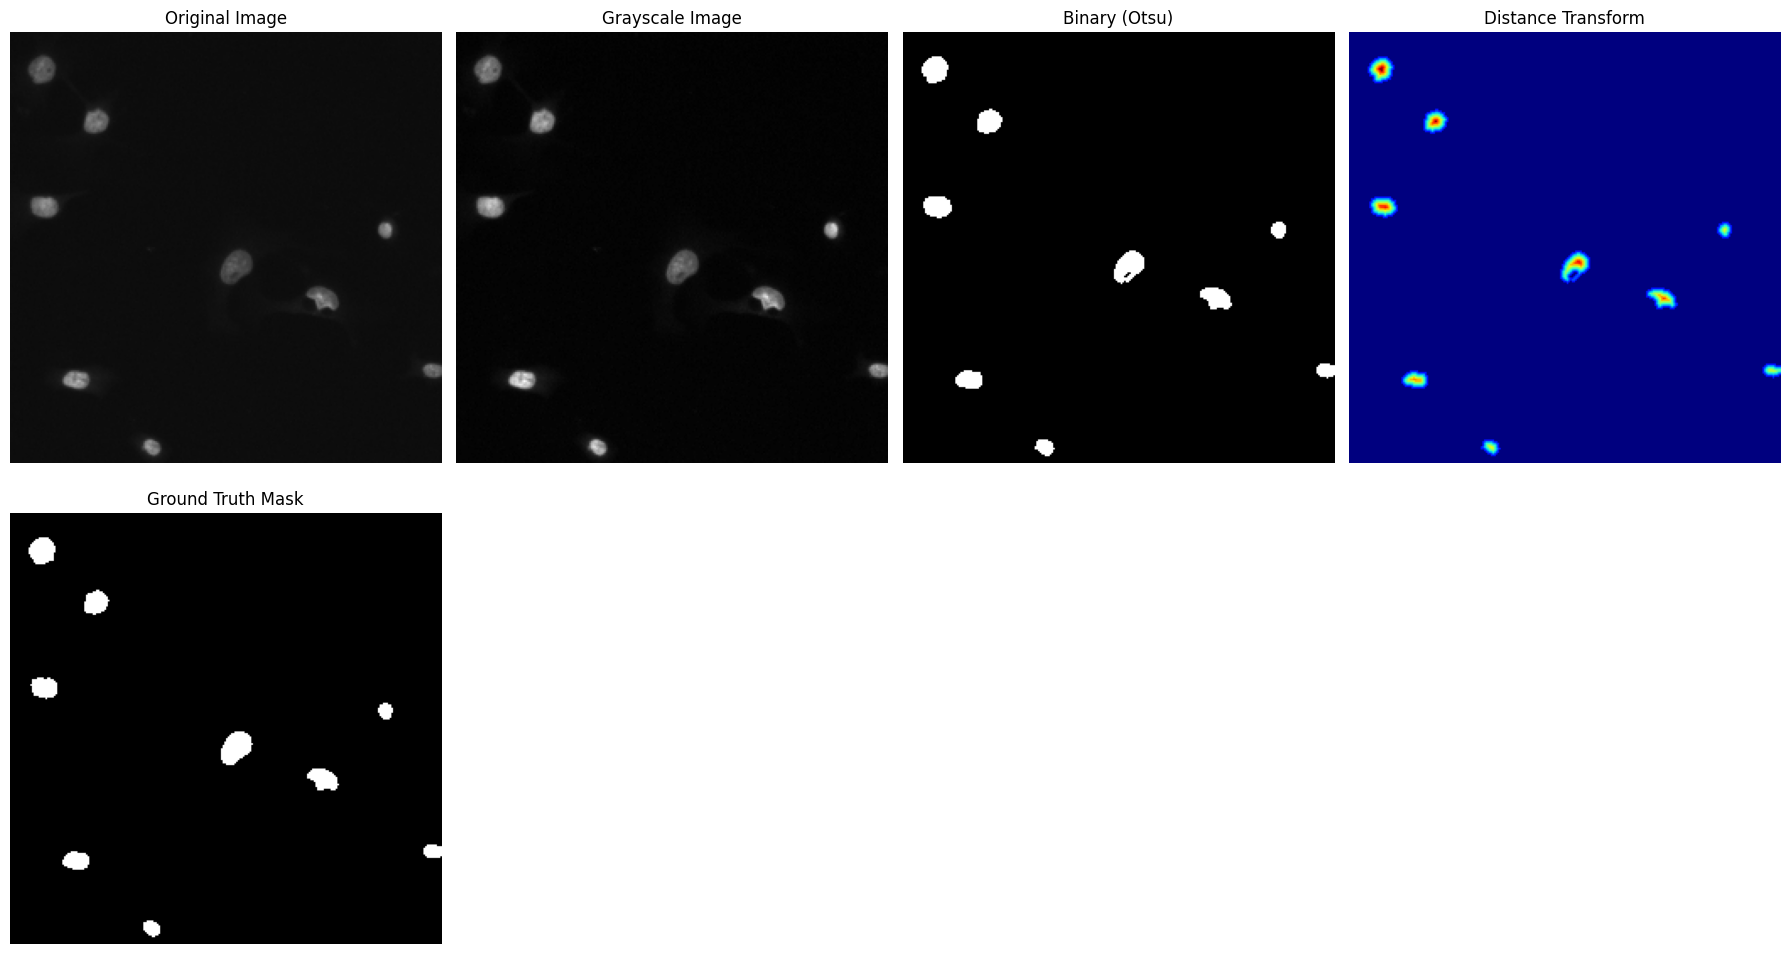

In [40]:
plt.figure(figsize=(18,10))

plt.subplot(2,4,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2,4,2)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')

plt.subplot(2,4,3)
plt.imshow(binary, cmap='gray')
plt.title("Binary (Otsu)")
plt.axis('off')

plt.subplot(2,4,4)
plt.imshow(dist_map, cmap='jet')
plt.title("Distance Transform")
plt.axis('off')

plt.subplot(2,4,5)
plt.imshow(gt_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

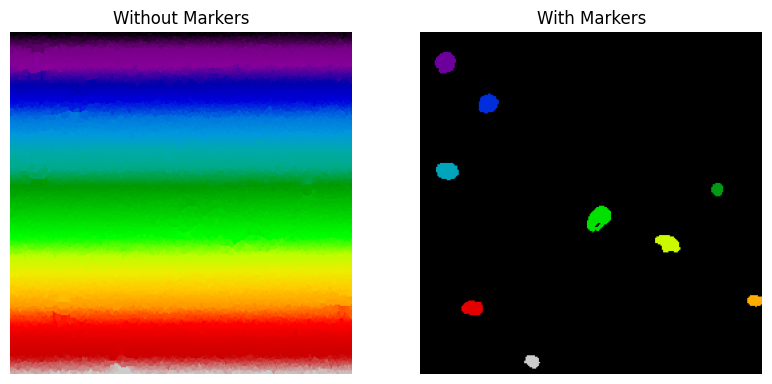

In [41]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,2)
plt.imshow(labels_naive, cmap='nipy_spectral')
plt.title("Without Markers")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(labels_markers, cmap='nipy_spectral')
plt.title("With Markers")
plt.axis('off')

plt.show()

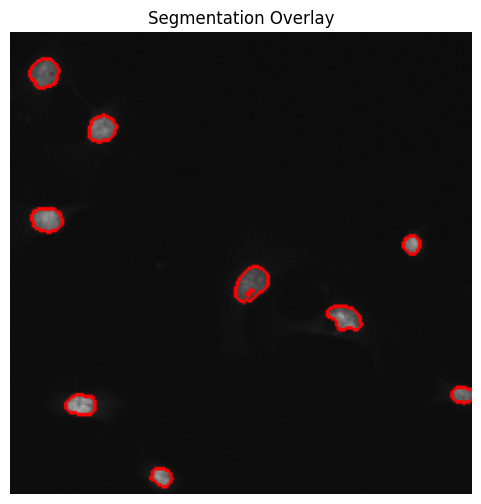

In [31]:
boundaries = find_boundaries(labels_markers)

overlay = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
overlay[boundaries] = [255, 0, 0]

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title("Segmentation Overlay")
plt.axis('off')
plt.show()